In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array
from sklearn.metrics import mean_squared_error
from datetime import datetime
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import pmdarima as pm

### Replace missing values with Zero and Gorup by month

In [157]:
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
df = pd.read_csv('../data.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [158]:
df.rename(columns = {'count':'nr'}, inplace = True)

In [159]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [160]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
df['day_of_week'] = [d.day_name() for d in df.index]
years = df['year'].unique()

In [161]:
df

,nr,year,month,day_of_week
date,,,,
2013-01-01,3720,2013,Jan,Tuesday
2013-01-02,3009,2013,Jan,Wednesday
2013-01-03,3086,2013,Jan,Thursday
2013-01-04,3015,2013,Jan,Friday
2013-01-05,2843,2013,Jan,Saturday
...,...,...,...,...
2019-12-27,3906,2019,Dec,Friday
2019-12-28,3782,2019,Dec,Saturday
2019-12-29,3790,2019,Dec,Sunday


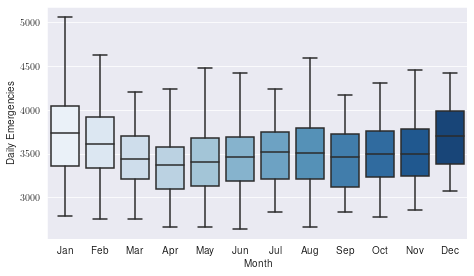

In [169]:
f = plt.figure(figsize=(17*cm, 10*cm))
ax = f.add_subplot(111)
sns.boxplot(x='month', y='nr', data=df, ax=ax, showfliers=False, palette='Blues')
ax.set_ylabel(ylabel='Daily Emergencies')
ax.set_xlabel(xlabel='Month')
plt.tight_layout()
plt.savefig('figures/emergencies_month.pdf')

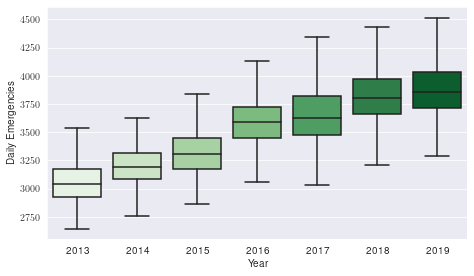

In [168]:
f = plt.figure(figsize=(17*cm, 10*cm))
ax = f.add_subplot(111)
sns.boxplot(x='year', y='nr', data=df, ax=ax, showfliers=False, palette='Greens')
ax.set_ylabel(ylabel='Daily Emergencies')
ax.set_xlabel(xlabel='Year')
plt.tight_layout()
plt.savefig('figures/emergencies_year.pdf')

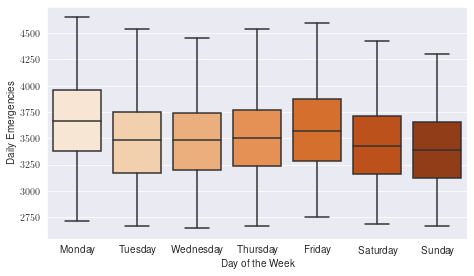

In [167]:
week_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
f = plt.figure(figsize=(17*cm, 10*cm))
ax = f.add_subplot(111)
sns.boxplot(x='day_of_week', y='nr', data=df, ax=ax, showfliers=False, palette='Oranges', order=week_order)
ax.set_ylabel(ylabel='Daily Emergencies')
ax.set_xlabel(xlabel='Day of the Week')
plt.tight_layout()
plt.savefig('figures/emergencies_week.pdf')

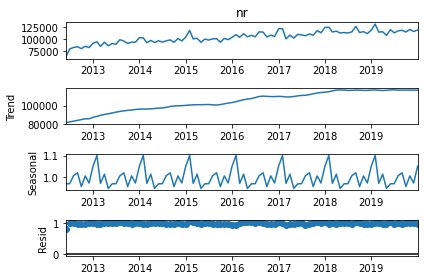

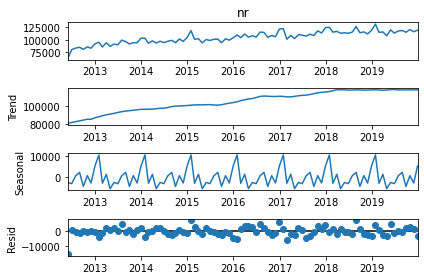

In [8]:
# Multiplicative Decomposition 
seasonal_decompose(df['nr'], model='multiplicative', extrapolate_trend='freq').plot();
# Additive Decomposition
seasonal_decompose(df['nr'], model='additive', extrapolate_trend='freq').plot();

In [9]:
# ADF Test
result = adfuller(df.nr.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Value s:')
    print(f'   {key}, {value}')

ADF Statistic: -2.4638373615921396
p-value: 0.12452279633688945
Critial Value s:
   1%, -3.5148692050781247
Critial Value s:
   5%, -2.8984085156250003
Critial Value s:
   10%, -2.58643890625


In [10]:
#SARIMA optimal parameters
smodel = pm.auto_arima(df[:80].nr, start_p=1, start_q=1,
                         test='adf',
                         max_p=25, max_q=25, m=6,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[6]             : AIC=1494.056, Time=0.66 sec
 ARIMA(0,2,0)(0,1,0)[6]             : AIC=1637.715, Time=0.02 sec
 ARIMA(1,2,0)(1,1,0)[6]             : AIC=1546.471, Time=0.28 sec
 ARIMA(0,2,1)(0,1,1)[6]             : AIC=inf, Time=1.19 sec
 ARIMA(1,2,1)(0,1,0)[6]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,1)(1,1,1)[6]             : AIC=inf, Time=1.08 sec
 ARIMA(1,2,1)(0,1,2)[6]             : AIC=1495.960, Time=1.37 sec
 ARIMA(1,2,1)(1,1,0)[6]             : AIC=1501.487, Time=0.70 sec
 ARIMA(1,2,1)(1,1,2)[6]             : AIC=inf, Time=1.13 sec
 ARIMA(1,2,0)(0,1,1)[6]             : AIC=1549.425, Time=0.24 sec
 ARIMA(2,2,1)(0,1,1)[6]             : AIC=1494.136, Time=2.40 sec
 ARIMA(1,2,2)(0,1,1)[6]             : AIC=inf, Time=1.11 sec
 ARIMA(0,2,0)(0,1,1)[6]             : AIC=1600.914, Time=0.10 sec
 ARIMA(0,2,2)(0,1,1)[6]             : AIC=inf, Time=0.67 sec
 ARIMA(2,2,0)(0,1,1)[6]             : AIC=1529.656, Time=0.35 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   80
Model:             SARIMAX(1, 2, 1)x(0, 1, 1, 6)   Log Likelihood                -743.028
Date:                           Wed, 28 Sep 2022   AIC                           1494.056
Time:                                   18:39:20   BIC                           1503.163
Sample:                                        0   HQIC                          1497.682
                                            - 80                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4465      0.143     -3.128      0.002      -0.726      -0.167
ma.L1         -0.8988      0.084    -10.674      0.000      -1.064      -0.734
ma.S.L6       -0.7860      0.145     -5.406      0.000      -1.071      -0.501
sigma2      5.241e+07   1.14e-09   4.58e+16      0.000    5.24e+07    5.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):                 0.46
Prob(Q):                              0.30   Prob(JB):                         0.79
Heteroskedasticity (H):               0.98   Skew:                             0.13
Prob(H) (two-sided):                  0.97   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+31. Standard errors may be unstable.
"""

In [11]:
smodel

ARIMA(order=(1, 2, 1), scoring_args={}, seasonal_order=(0, 1, 1, 6),
      suppress_warnings=True, with_intercept=False)

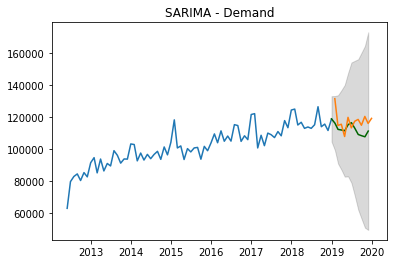

In [12]:
n_periods = 12
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df[:80].index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
cm = 1/2.54 
plt.plot(df[:80].nr)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.plot(df[80:].nr)
plt.title("SARIMA - Demand")
plt.show()

In [13]:
actual = df[80:].nr

In [14]:
rmse = sqrt(mean_squared_error(fitted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7107.247


In [15]:
mae = mean_absolute_error(fitted, actual)
print('Test MAE: %.3f' % mae)

Test MAE: 6027.762


In [16]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [17]:
MAPE(fitted, actual)

5.375723185397973

In [18]:
emergencies_prediction_sarima = fitted_series
%store emergencies_prediction_sarima

Stored 'emergencies_prediction_sarima' (Series)
